# Simple demo for table reconstruction


## Import packages

In [1]:
import cv2
import torch
import numpy as np

## Import packages used for visualizing

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

## Force CPU

In [3]:
torch.cuda.is_available = lambda: False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Prepare image

## Read sample image

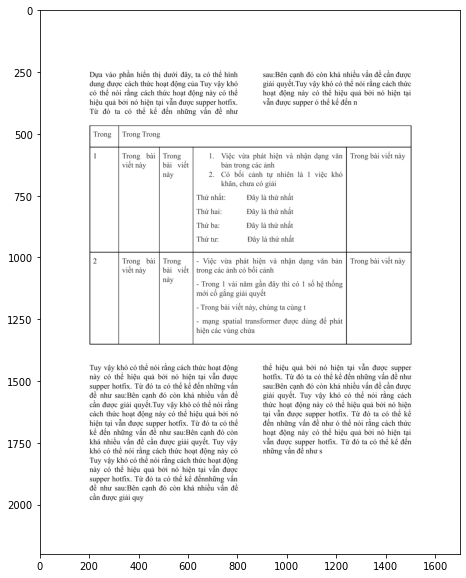

In [4]:
image = cv2.imread("table.png")

plt.imshow(image)

# TL:DR

In [5]:
from table_reconstruction import TableExtraction

In [6]:
extraction = TableExtraction(device=device)

Using cpu for table detection


In [7]:
tables = extraction.extract(image)

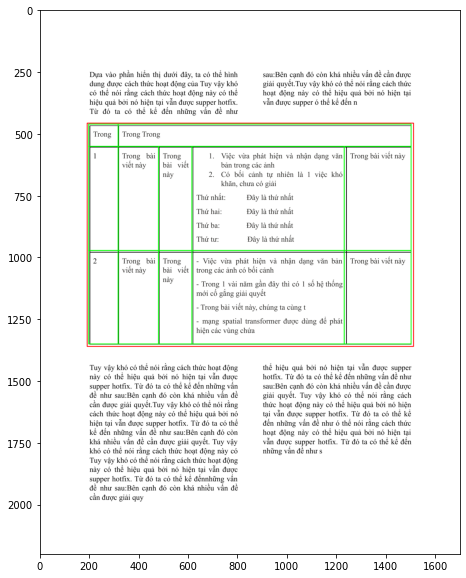

In [8]:
visualization = image.copy()
for table in tables:
    t_x_min, t_x_max, t_y_min, t_y_max = table.coordinate
    cv2.rectangle(
        visualization,
        (t_x_min, t_y_min),
        (t_x_max, t_y_max),
        (255, 0, 0),
        thickness=2,
        lineType=cv2.LINE_AA,
    )
    for cell in table.cells:
        x_min, x_max, y_min, y_max = cell.coordinate
        cv2.rectangle(
            visualization,
            (x_min + t_x_min, y_min + t_y_min),
            (x_max + t_x_min, y_max + t_y_min),
            (0, 255, 0),
            thickness=2,
            lineType=cv2.LINE_AA,
        )

plt.imshow(visualization)

# Reconstruct table

## Detect table region

In [9]:
from table_reconstruction.table_detection.detector import TableDetector

In [10]:
table_detector = TableDetector(device=device)

Using cpu for table detection


In [11]:
table_regions = table_detector.predict([image])

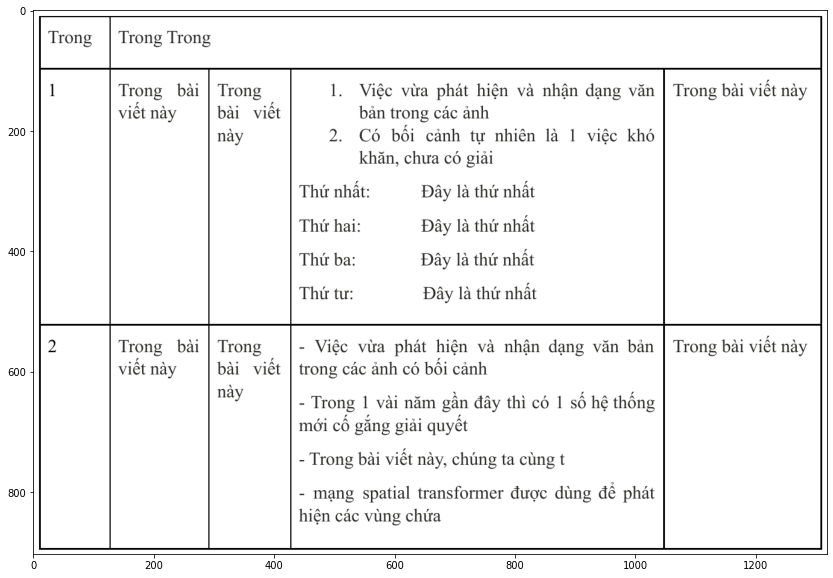

In [12]:
x_min, y_min, x_max, y_max = table_regions[0][0]

img = image[y_min:y_max, x_min:x_max]
plt.imshow(img)

## Segment lines

In [13]:
from table_reconstruction.line_segmentation.line_segment import LineSegmentation

In [14]:
h, w, _ = img.shape
padding_img = np.ones((h + 10, w + 10, 3), dtype=np.uint8) * 255
padding_img[5 : h + 5, 5 : w + 5, :] = img

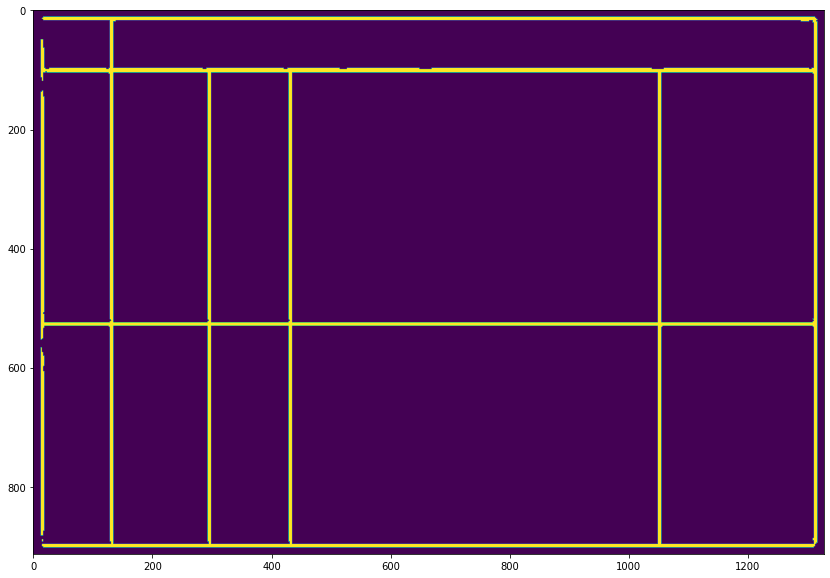

In [15]:
line_segmentation = LineSegmentation(device=device)
mask = line_segmentation.predict(padding_img)
plt.imshow(mask)

# Predict lines and reconstruct grid

In [16]:
from table_reconstruction.utils.cell_utils import (
    calculate_cell_coordinate,
    get_intersection_points,
    predict_relation,
    sort_cell,
)
from table_reconstruction.utils.lines_utils import get_coordinates
from table_reconstruction.utils.mask_utils import normalize
from table_reconstruction.utils.table_utils import (
    DirectedGraph,
    convertSpanCell2DocxCoord,
)

In [17]:
mask = normalize(img, mask_img=mask)
mask = np.array(mask[5 : h + 5, 5 : w + 5])

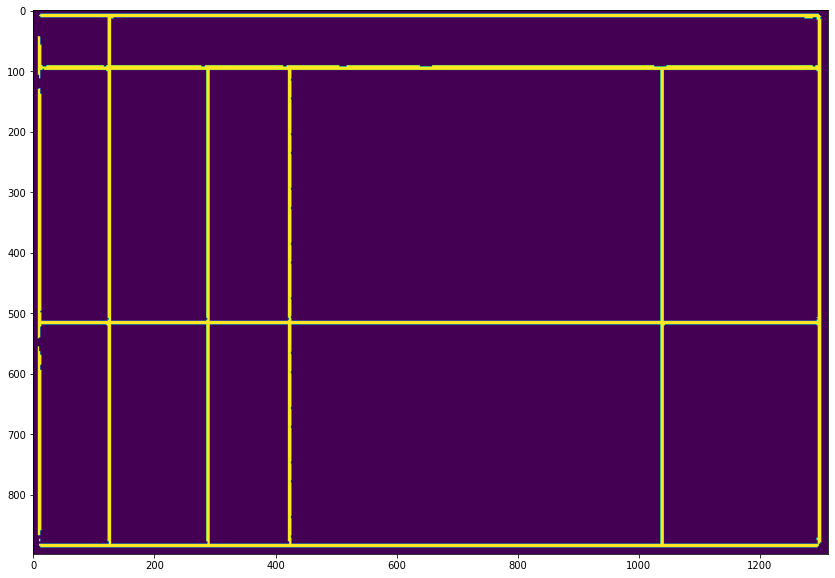

In [18]:
plt.imshow(mask)

In [19]:
normalize_thresh = 15
tab_coord, vertical_lines_coord, horizontal_lines_coord = get_coordinates(
    mask, ths=normalize_thresh
)


intersect_points, fake_intersect_points = get_intersection_points(
    horizontal_lines_coord, vertical_lines_coord, tab_coord
)

cells = calculate_cell_coordinate(
    intersect_points.copy(),
    False,
    normalize_thresh,
    [horizontal_lines_coord, vertical_lines_coord],
)

fake_cells = calculate_cell_coordinate(
    fake_intersect_points.copy(), True, normalize_thresh
)

if len(cells) <= 1:
    pass
cells = sort_cell(cells=np.array(cells))
fake_cells = sort_cell(cells=np.array(fake_cells))

hor_couple_ids, ver_couple_ids = predict_relation(cells)

H_Graph = DirectedGraph(len(cells))
H_Graph.add_edges(hor_couple_ids)
nb_col = H_Graph.findLongestPath()
V_Graph = DirectedGraph(len(cells))
V_Graph.add_edges(ver_couple_ids)
nb_row = V_Graph.findLongestPath()

span_list = convertSpanCell2DocxCoord(
    cells, fake_cells, list(range(len(cells))), nb_col
)

In [20]:
print("Number of colums: {}".format(nb_col))
print("Number of rows: {}".format(nb_row))

for coord, span in zip(cells, span_list):
    print(coord, span)

Number of colums: 5
Number of rows: 3
[6, 125, 4, 94] {'id': 0, 'x': [0, 0], 'y': [0, 0]}
[125, 1308, 4, 94] {'id': 1, 'x': [1, 4], 'y': [0, 0]}
[6, 125, 94, 515] {'id': 2, 'x': [0, 0], 'y': [1, 1]}
[125, 288, 94, 515] {'id': 3, 'x': [1, 1], 'y': [1, 1]}
[288, 423, 94, 515] {'id': 4, 'x': [2, 2], 'y': [1, 1]}
[423, 1038, 94, 515] {'id': 5, 'x': [3, 3], 'y': [1, 1]}
[1038, 1308, 94, 515] {'id': 6, 'x': [4, 4], 'y': [1, 1]}
[6, 125, 515, 893] {'id': 7, 'x': [0, 0], 'y': [2, 2]}
[125, 288, 515, 893] {'id': 8, 'x': [1, 1], 'y': [2, 2]}
[288, 423, 515, 893] {'id': 9, 'x': [2, 2], 'y': [2, 2]}
[423, 1038, 515, 893] {'id': 10, 'x': [3, 3], 'y': [2, 2]}
[1038, 1308, 515, 893] {'id': 11, 'x': [4, 4], 'y': [2, 2]}
